In [1]:
import os, sys
sys.path.append('../src')

from copulae1 import *
import plotly.express as px
import plotly.figure_factory as ff

import plotly.graph_objects as go

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import json
with open('../src/configs/config_future_brr_new_MM.json','r') as file:
    config = json.load(file)
config
data_name = config['data_name']
calibration_method  = config['calibration_method']
OHR = pd.read_hdf('../results/'+data_name +'/'+calibration_method+'/best_h.h5')
if not os.path.exists("../results/" + data_name + "/MLE/reports"):
	print("Create new folder for results")
	os.mkdir("../results/" + data_name + "/MLE/reports")
	os.mkdir("../results/" + data_name + "/MM/reports")
    
if calibration_method == "MLE":
    report_path = "../results/" + data_name + "/MLE/reports/"
    result_path = "../results/" + data_name + "/MLE/"
elif calibration_method == "MM":
    report_path = "../results/" + data_name + "/MM/reports/"
    result_path = "../results/" + data_name + "/MM/"

In [3]:
config

{'data_name': 'future_brr_new',
 'spot_name': 'log return bitcoin',
 'future_name': 'log return future',
 'calibration_method': 'MM',
 'q_arr': [0.05, 0.1, 0.9, 0.95],
 'k_ERM': [10],
 'q_arr_ES': [0.01, 0.05],
 'q_arr_VaR': [0.01, 0.05],
 'h_Clip': [0, 99999]}

In [69]:
natp_path = '../_mathematica/data_30Days/'
natp_ls = os.listdir(natp_path)
natp_h = [l for l in natp_ls if l.endswith('_h.csv')]
file_names = [l.replace('_h','') for l in natp_h]
OHR_combined = []
for i in range(len(natp_h)):
    _natp_h = pd.DataFrame(open(natp_path+natp_h[i], 'r').readlines())
    _natp_h = _natp_h.iloc[1:7,:]
    file_name = natp_h[i].replace('_h','')
    for i in range(len(_natp_h)):
        _natp_h.iloc[i,0] = np.float32(_natp_h.iloc[i,0].replace('\n',''))
    _natp_h.columns = ['NIG_factor']
    _natp_h.index = ['Variance', 'VaR q=0.01', 'VaR q=0.05', 'ES q=0.01', 'ES q=0.05', 'ERM k=10']
    _natp_h = _natp_h.T
    
    OHR_combined.append(OHR.loc[:,file_name].append(_natp_h))
OHR = pd.concat(OHR_combined, axis=1, keys=file_names).dropna(axis=1)

In [4]:
Copula_names = list(OHR.index)

In [5]:
temp = []
for C in Copula_names:
    hs_by_Copula = OHR.loc[C:C,:].melt()
    hs_by_Copula.columns = ['file_name', 'risk_measure', 'OHR']
    hs_by_Copula.loc[:, 'copula'] = C
    temp.append(hs_by_Copula)

OHR_to_math = pd.concat(temp, axis=0)
OHR_to_math.to_csv(result_path +'OHR.csv')

In [6]:
Copula_names = list(OHR.index)
risk_measures = OHR.loc[:,'0.csv'].columns
data_path = '../processed_data/'+config['data_name']
ls = list(OHR.melt().variable_0.unique())
# OHR.loc[:,'0.csv'].loc[:,risk_measures[0]]

In [7]:
for i,r in enumerate(risk_measures):
    print(i, r)

0 Variance
1 ERM k=10
2 ES q=0.01
3 ES q=0.05
4 VaR q=0.01
5 VaR q=0.05


In [8]:
# rm = 'ES q=0.05'
rm = risk_measures[0]
rm

'Variance'

In [9]:
rh_arr = []
rs_arr = []
rf_arr = []
for file in ls:
    test = pd.read_csv(data_path +'/test/'+file)
    test.Date = pd.to_datetime(test.Date)
    rs = np.array(test.loc[:, config['spot_name']])
    rf = np.array(test.loc[:, config['future_name']])
    h_arr = OHR.loc[:,file].loc[:,rm]
    rh = rs - np.array(h_arr).reshape((len(h_arr),-1))*rf
    rh = pd.DataFrame(rh, index=Copula_names, columns=test.Date)
    rh_arr.append(rh)
    
    rs = pd.Series(rs, index=test.Date)
    rf = pd.Series(rf, index=test.Date)
    rs_arr.append(rs)
    rf_arr.append(rf)
    
rh = pd.concat(rh_arr, axis=1)
rh = rh.sort_index(axis=1)
rs = pd.concat(rs_arr)
rs = rs.sort_index()

rf = pd.concat(rf_arr)
rf = rf.sort_index()

rh = rh.apply(pd.to_numeric)

In [10]:
tau_arr = []
date_arr = []
for file in ls:
    train = pd.read_csv(data_path +'/train/'+file)
    test = pd.read_csv(data_path +'/test/'+file)

    test.Date = pd.to_datetime(test.Date)
    date_arr.append(test.Date.iloc[0])
    
    train_tau = stats.kendalltau(train.loc[:,config['spot_name']], train.loc[:,config['future_name']])[0]
    test_tau = stats.kendalltau(test.loc[:,config['spot_name']], test.loc[:,config['future_name']])[0]

    tau_arr.append(train_tau - test_tau)

tau_arr = pd.Series(tau_arr, index=date_arr)
tau_arr = tau_arr.sort_index()
tau_arr.loc[rh.columns[0]] = tau_arr.iloc[0] # add a row for plotting
tau_arr = tau_arr.sort_index()

In [11]:
# plt.figure(figsize=(20,5))
# plt.plot(rs, 'r')
# q = 0.05

# rs_U = rs.loc[rs<=np.quantile(rs,q)]
# plt.plot(np.array(rs_U.index),np.array(rs_U),'rx')

# rs_L = rs.loc[rs>np.quantile(rs,1-q)]
# plt.plot(np.array(rs_L.index),np.array(rs_L),'r+')

# rf_U = rf.loc[rf<=np.quantile(rf,q)]
# plt.plot(np.array(rf_U.index),np.array(rf_U),'bx')

# rf_L = rf.loc[rf>np.quantile(rf,1-q)]
# plt.plot(np.array(rf_L.index),np.array(rf_L),'b+')

# plt.plot(rf, 'b')

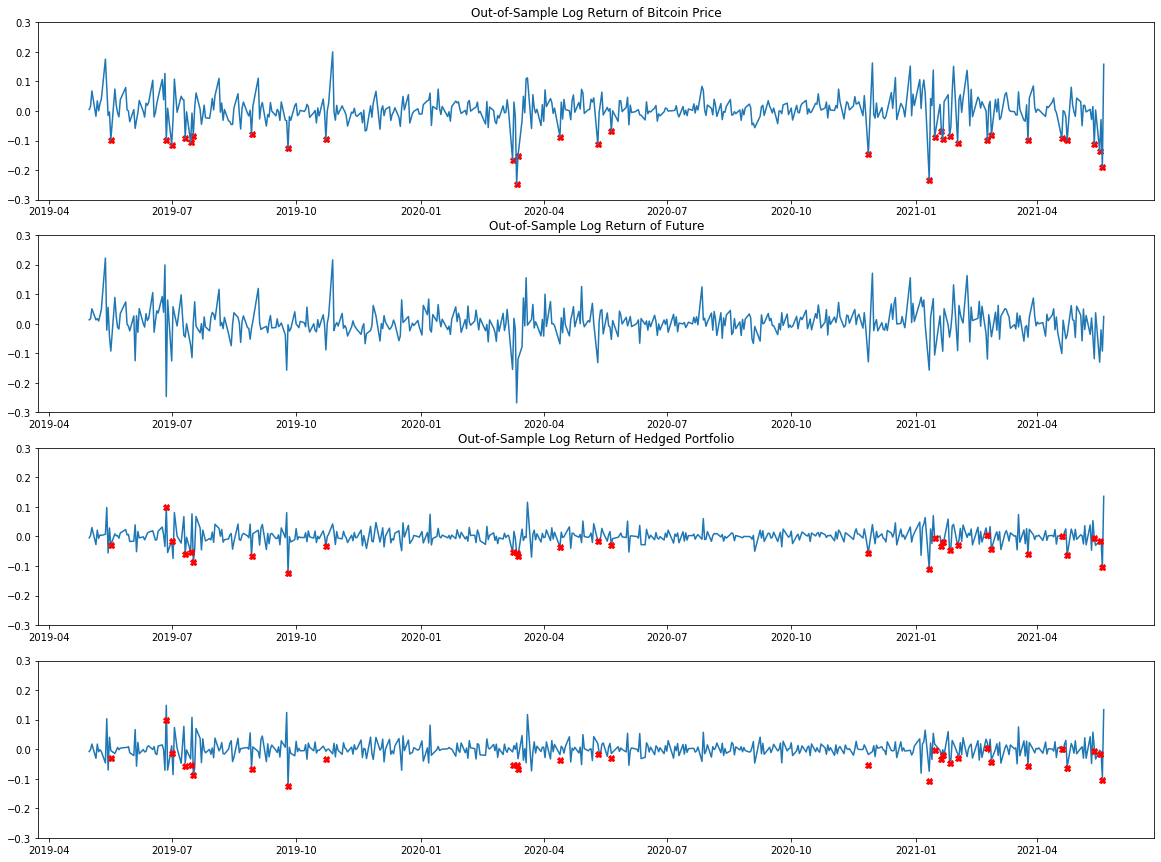

In [12]:
_id_rs = (rs<=np.quantile(rs,30/len(rs))) # 30 smallest rs
_id_rf = (rf<=np.quantile(rs,30/len(rf))) # 30 smallest rs

fig, ax = plt.subplots(figsize=(20,15), nrows=4, ncols=1)
ax[0].plot(rs[_id_rs],'rX')
ax[0].plot(rs)
ax[0].set_ylim((-0.3,0.3))
ax[0].set_title("Out-of-Sample Log Return of Bitcoin Price")

# ax[1].plot(rf[_id_rf],'rX')
ax[1].plot(rf)
ax[1].set_ylim((-0.3,0.3))
ax[1].set_title("Out-of-Sample Log Return of Future")

C = 'Gumbel'
ax[2].plot(rh.loc[C,:])
ax[2].plot(rh.T.loc[_id_rs, C], 'rX')
ax[2].set_ylim((-0.3,0.3))
ax[2].set_title("Out-of-Sample Log Return of Hedged Portfolio")

ax[3].plot(rs - rf)
ax[3].set_ylim((-0.3,0.3))
ax[3].plot(rh.T.loc[_id_rs, C], 'rX')

# plt.savefig('../latex/_pics/OOSreturns_compare.pdf')

In [13]:
print(1-ERM_estimate_trapezoidal(10,rh.loc['Gumbel'])/ERM_estimate_trapezoidal(10,rs), 
      1-ERM_estimate_trapezoidal(10,rs-rf)/ERM_estimate_trapezoidal(10,rs))

0.43524684376471623 0.40323637834137926


In [14]:
print(1-VaR(0.01,rh.loc['Gumbel'])/VaR(0.01,rs), 
      1-VaR(0.01,rs-rf)/VaR(0.01,rs))

0.5206908361612395 0.4831170341161585


In [15]:
print(1-VaR(0.05,rh.loc['Gumbel'])/VaR(0.05,rs), 
      1-VaR(0.05,rs-rf)/VaR(0.05,rs))

0.45024799362350953 0.4284760170327614


In [16]:
print(1-ES(0.05,rh.loc['Gumbel'])/ES(0.05,rs), 
      1-ES(0.05,rs-rf)/ES(0.05,rs))

0.47373460213984075 0.4632479567708383


In [17]:
print(1-ES(0.01,rh.loc['Gumbel'])/ES(0.01,rs), 
      1-ES(0.01,rs-rf)/ES(0.01,rs))

0.49743383098249916 0.5136251141643031


In [18]:
print(1-Variance(rh.loc['Gumbel'])/Variance(rs), 
      1-Variance(rs-rf)/Variance(rs))

0.6814436087064912 0.6388472912529094


(-0.4, 0.4)

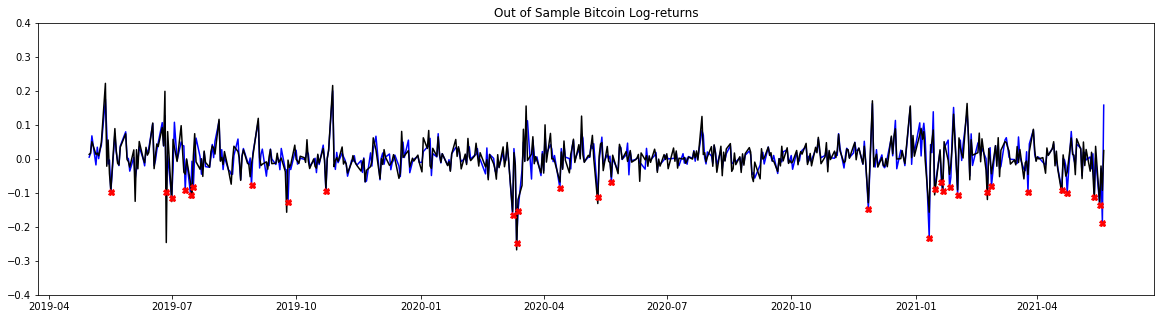

In [19]:
plt.figure(figsize=(20,5))
q=0.1
plt.title('Out of Sample Bitcoin Log-returns')
# print(np.sum(_id))
# _id = (rs<=np.quantile(rs,q)) & (rf<=np.quantile(rf,q)) 
_id = (rs<=np.quantile(rs,30/len(rs))) # 30 smallest rs

plt.plot(rs, 'b')
plt.plot(rf, 'black')
# _id = (rs<=np.quantile(rs,q)) & (rf<=np.quantile(rf,q)) 
plt.plot(rs[_id],'rX')
plt.ylim((-0.4,0.4))

# plt.plot(rf[_id],'bX')
# plt.savefig('../latex/_pics/OOSBitcoin.png', transparent=True)
# _id = (rs>np.quantile(rs,1-q)) & (rf>np.quantile(rf,1-q)) 
# plt.plot(rs[_id],'rX')
# plt.plot(rf[_id],'bX')

In [34]:
# plt.figure(figsize=(20,5))
# plt.plot(rs, 'r')
# q = 0.1

# rs_U = rs.loc[rs<=np.quantile(rs,q)]
# plt.plot(np.array(rs_U.index),np.array(rs_U),'rx')

# rs_L = rs.loc[rs>np.quantile(rs,1-q)]
# plt.plot(np.array(rs_L.index),np.array(rs_L),'r+')

# rf_U = rf.loc[rf<=np.quantile(rf,q)]
# plt.plot(np.array(rf_U.index),np.array(rf_U),'bx')

# rf_L = rf.loc[rf>np.quantile(rf,1-q)]
# plt.plot(np.array(rf_L.index),np.array(rf_L),'b+')

# plt.plot(rf, 'b')

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



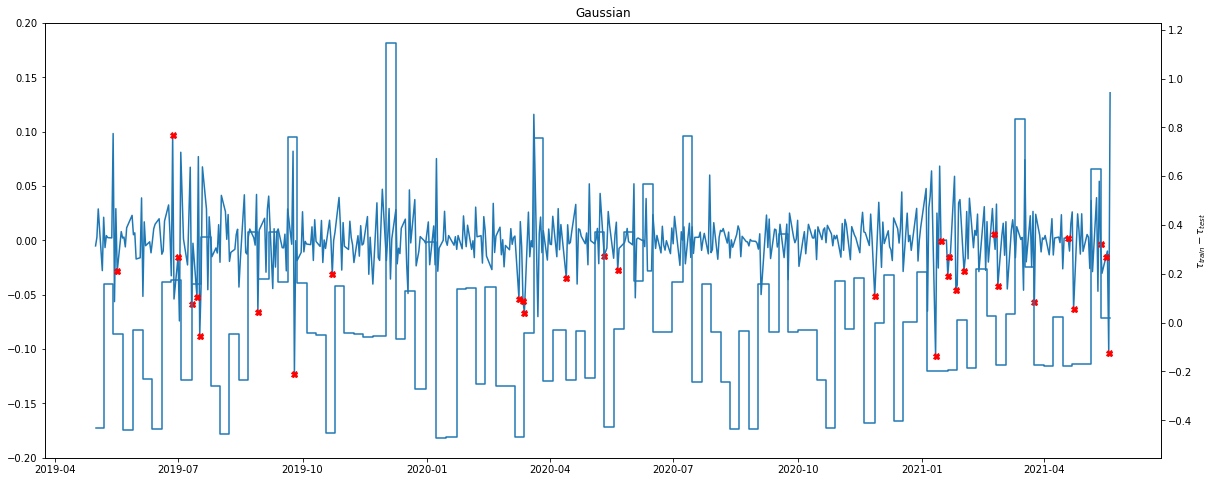

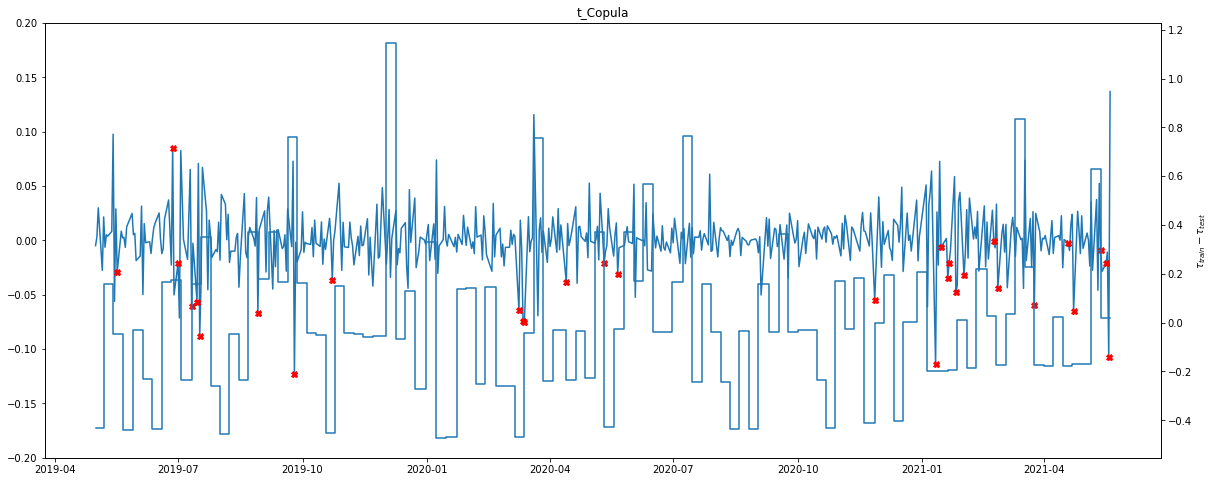

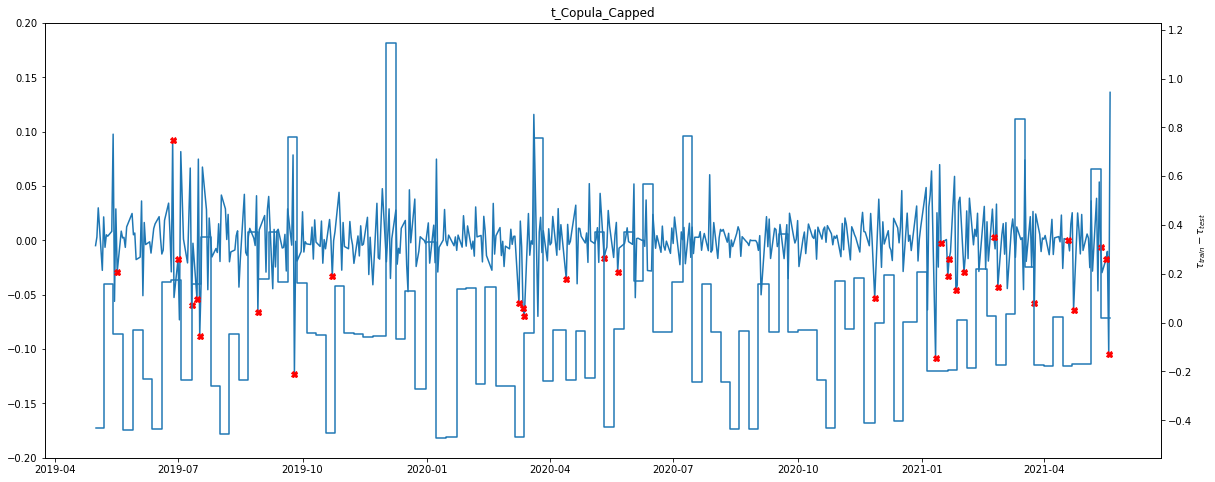

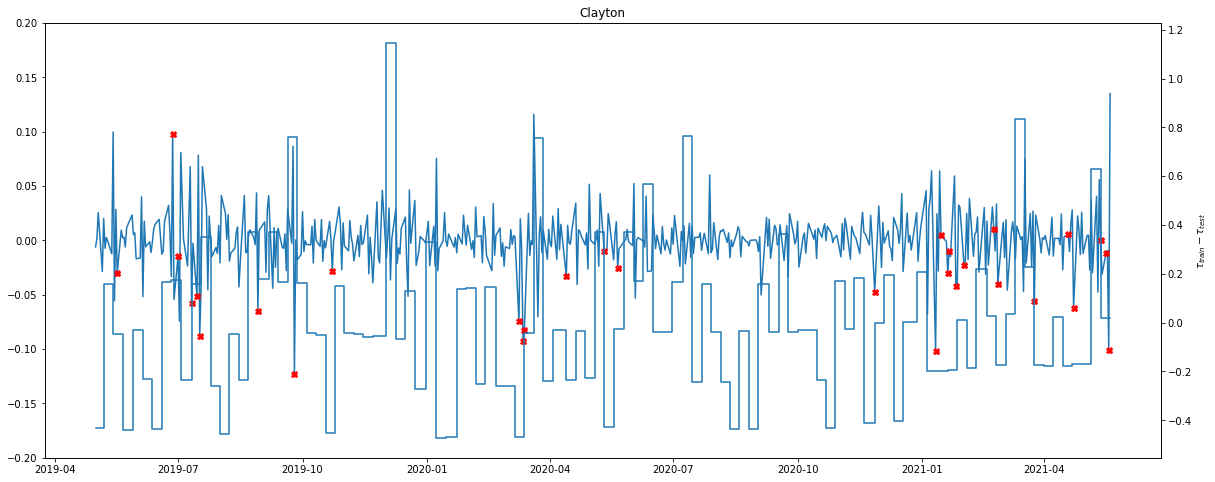

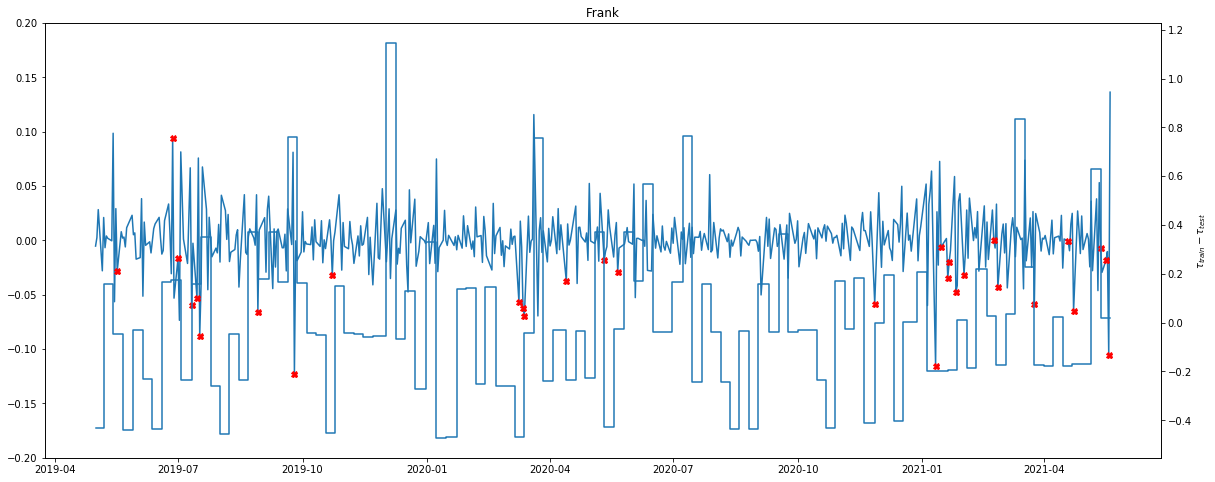

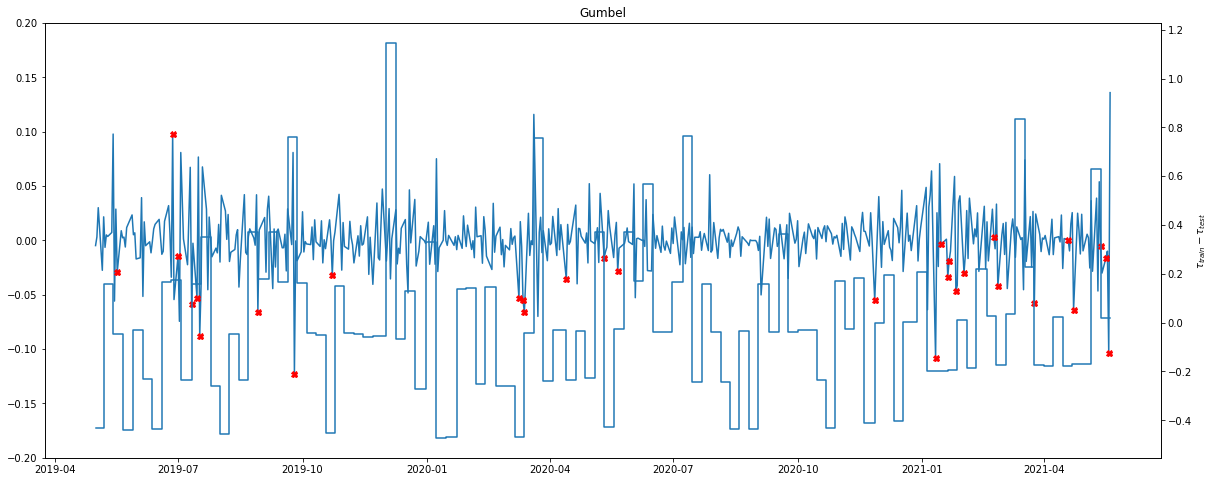

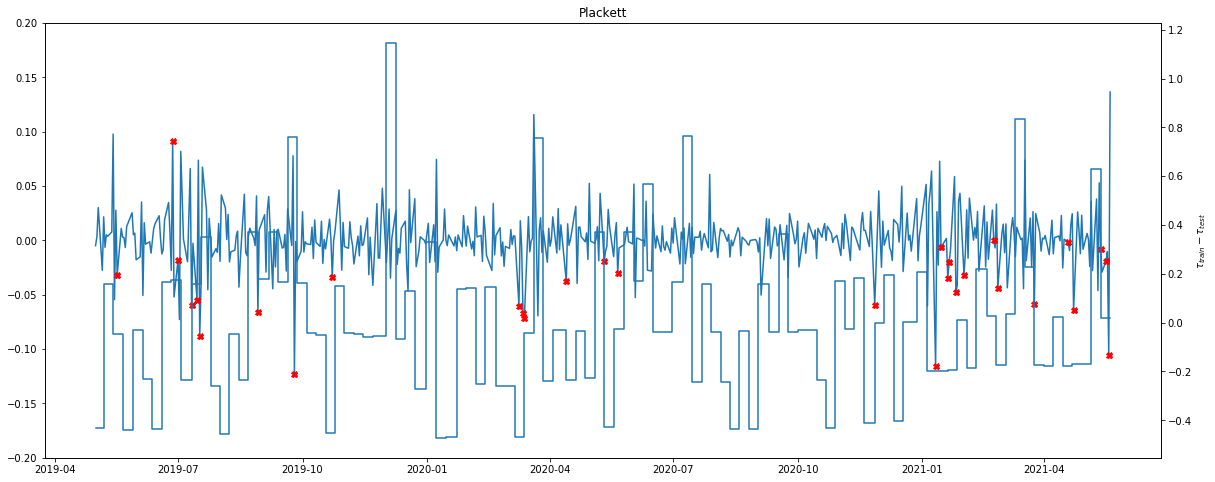

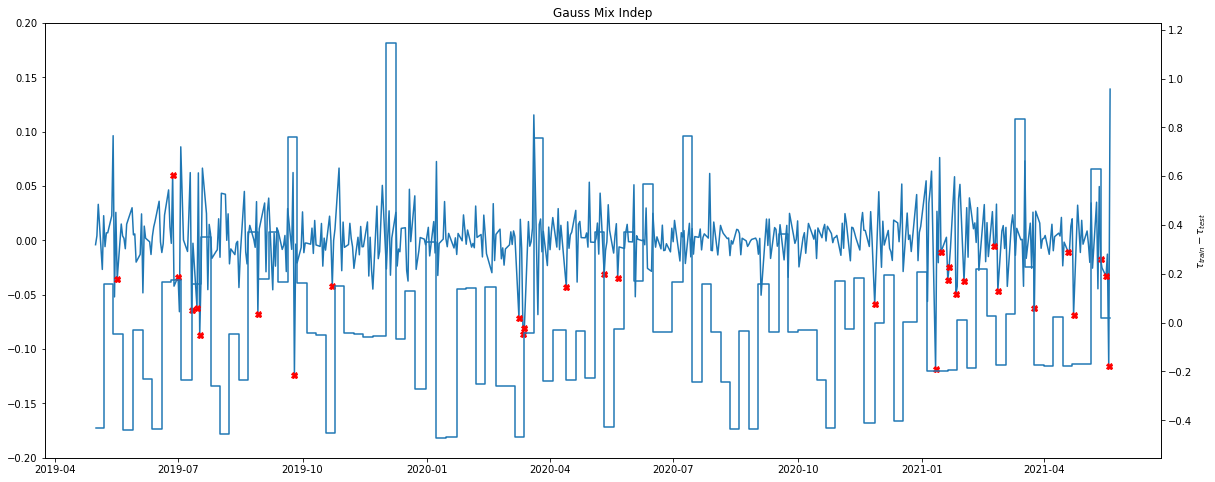

In [20]:
for i in range(len(Copula_names)):
    fig, ax1 = plt.subplots(figsize=(20,1*len(Copula_names)))
    ax2 = ax1.twinx()  
    C = Copula_names[i]
#     plt.figure(figsize=(20,5))
    ax1.set_title(Copula_names[i])
    ax1.plot(rh.loc[C,:])
    ax1.plot(rh.T.loc[_id, C], 'rX')
    ax1.set_ylim((-0.2,0.2))

    ax2.step(tau_arr.index, tau_arr)
    ax2.set_ylabel(r'$\tau_{train} - \tau_{test}$')

#     plt.plot(rh.loc[C,rs_L.index],'rx')
#     plt.plot(rh.loc[C,rs_U.index],'r+')
#     plt.plot(rh.loc[C,rf_L.index],'bx')
#     plt.plot(rh.loc[C,rf_U.index],'b+')
#     plt.ylim((-0.2,0.2))
# plt.hlines(np.quantile(rh.loc[Copula_names[0],:], q), xmin=rh.columns[0], xmax=rh.columns[-1])
# plt.hlines(np.quantile(rh.loc[Copula_names[0],:], 1-q), xmin=rh.columns[0], xmax=rh.columns[-1])

(-0.4, 0.4)

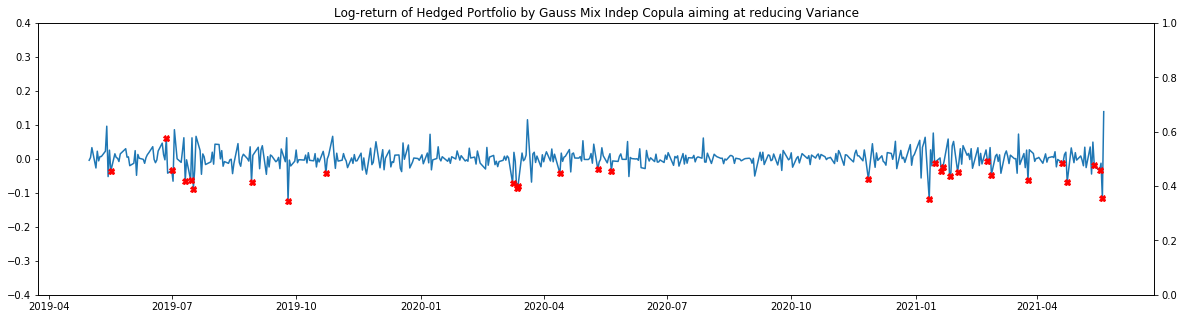

In [21]:
fig, ax1 = plt.subplots(figsize=(20,5))
ax2 = ax1.twinx()  
C = Copula_names[i]
#     plt.figure(figsize=(20,5))
ax1.set_title('Log-return of Hedged Portfolio by '+ Copula_names[i]+' Copula aiming at reducing '+rm)
ax1.plot(rh.loc[C,:])
ax1.plot(rh.T.loc[_id, C], 'rX')
ax1.set_ylim((-0.4,0.4))
# plt.savefig('../latex/_pics/Gumbel_rh.png', transparent=True)
# _rh = rh.loc[C,:]
# S = pd.Series({'mean':np.mean(_rh), 
#  'std':np.std(_rh),
#  'skew':stats.skew(_rh),
#  'kurt':stats.kurtosis(_rh),
#  'max': np.max(_rh),
#  'UQ': np.quantile(_rh, 0.75),
#  'median': np.quantile(_rh, 0.5),
#  'LQ': np.quantile(_rh, 0.25), 
#  'min':np.min(_rh)})
# plt.figure(figsize=(5,5))
# sns.distplot(_rh)
# print(S)

In [22]:
print(result_path)

../results/future_brr_new/MM/


In [23]:
rs.index

DatetimeIndex(['2019-05-01', '2019-05-02', '2019-05-03', '2019-05-06',
               '2019-05-07', '2019-05-08', '2019-05-09', '2019-05-10',
               '2019-05-13', '2019-05-14',
               ...
               '2021-05-07', '2021-05-10', '2021-05-11', '2021-05-12',
               '2021-05-13', '2021-05-14', '2021-05-17', '2021-05-18',
               '2021-05-19', '2021-05-20'],
              dtype='datetime64[ns]', name='Date', length=520, freq=None)

In [27]:
for C in rh.index:
    rh.loc[C,:].to_csv(result_path + 'rhs/%s_%s.csv'%(C, rm))

Gaussian
t_Copula
t_Copula_Capped
Clayton
Frank
Gumbel
Plackett
Gauss Mix Indep


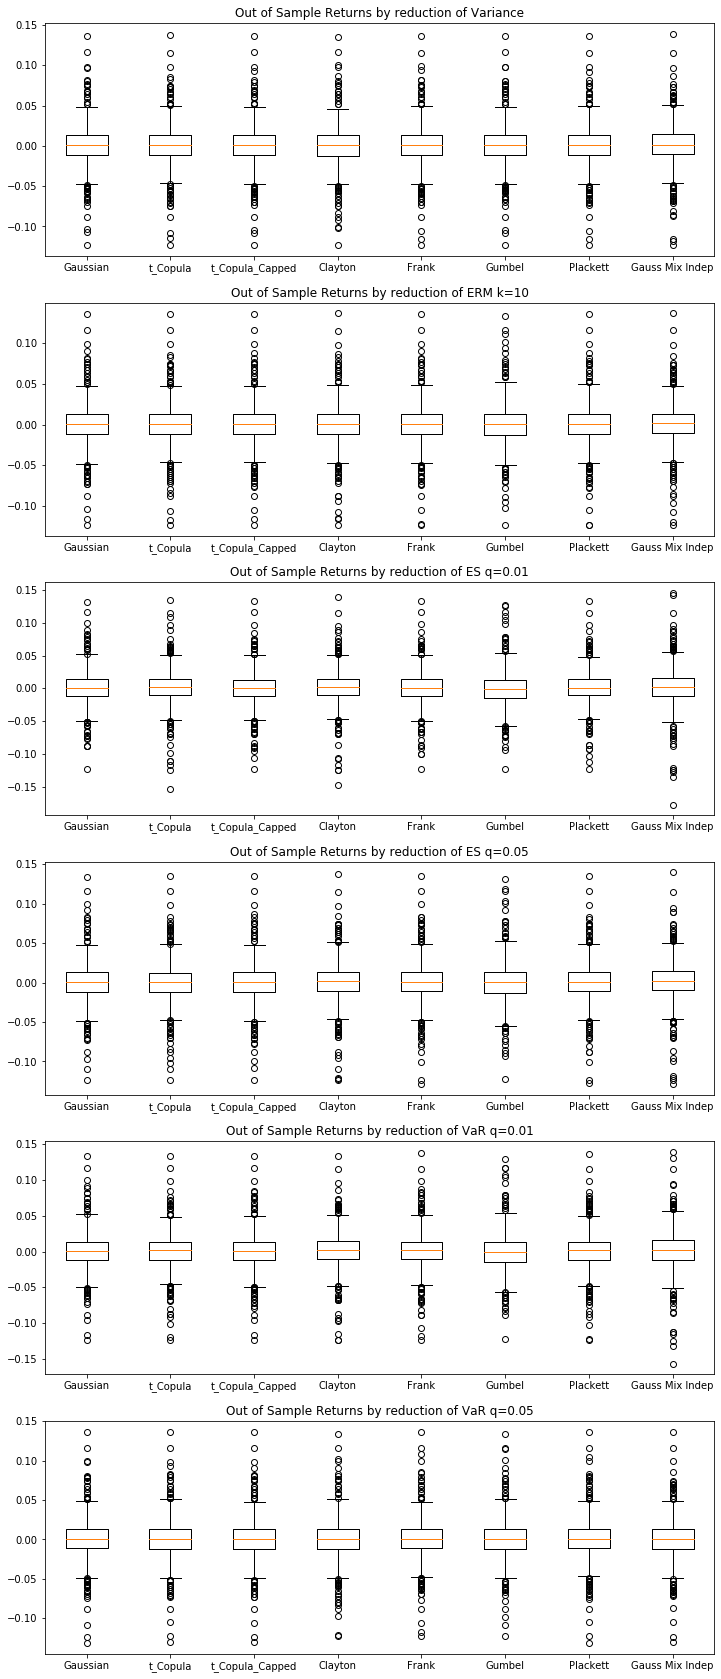

In [37]:
from plotly.subplots import make_subplots
fig, ax = plt.subplots(len(risk_measures), 1, figsize=(12,5*len(risk_measures)))
for i, rm in enumerate(risk_measures):
    rh_arr = []
    rs_arr = []
    rf_arr = []
    for file in ls:
        test = pd.read_csv(data_path +'/test/'+file)
        test.Date = pd.to_datetime(test.Date)
        rs = np.array(test.loc[:, config['spot_name']])
        rf = np.array(test.loc[:, config['future_name']])
        h_arr = OHR.loc[:,file].loc[:,rm]
        rh = rs - np.array(h_arr).reshape((len(h_arr),-1))*rf
        rh = pd.DataFrame(rh, index=Copula_names, columns=test.Date)
        rh_arr.append(rh)

        rs = pd.Series(rs, index=test.Date)
        rf = pd.Series(rf, index=test.Date)
        rs_arr.append(rs)
        rf_arr.append(rf)

    rh = pd.concat(rh_arr, axis=1)
    rh = rh.sort_index(axis=1)
    rs = pd.concat(rs_arr)
    rs = rs.sort_index()

    rf = pd.concat(rf_arr)
    rf = rf.sort_index()

    rh = rh.apply(pd.to_numeric)
    ax[i].boxplot(rh)
    ax[i].set_xticklabels(Copula_names)
    ax[i].set_title("Out of Sample Returns by reduction of %s" %rm)
    M = np.mean(rh, axis=1)
    STD = np.std(rh, axis=1)

    MAX = np.max(rh, axis=1)
    MAX_date = rh.isin(MAX).idxmax(axis=1)

    UQ = rh.apply(lambda x: np.quantile(x, 0.75, interpolation='higher'), axis=1)
    UQ_date = rh.isin(UQ).idxmax(axis=1)

    LQ = rh.apply(lambda x: np.quantile(x, 0.25, interpolation='higher'), axis=1)
    LQ_date = rh.isin(LQ).idxmax(axis=1)

    MIN = np.min(rh, axis=1)
    MIN_date = rh.isin(MIN).idxmax(axis=1)

    rh_stats = pd.concat([M, STD, MAX, MAX_date, UQ, UQ_date, LQ, LQ_date, MIN, MIN_date], axis=1)
    rh_stats.columns = ['mean', 'std', 
                        'max', 'max date',
                        'UQ', 'UQ date', 
                        'LQ', 'LQ date',
                        'min', 'min date']
    rh_stats.to_html(result_path+'rh_stats_%s.html'%rm)

    for C in rh.index:
        rh.loc[C,:].to_csv(result_path + 'rhs/%s_%s.csv'%(C, rm))

    for C in Copula_names:
        _rh = rh.loc[C,:]

        fig = make_subplots(
            rows=3, cols=2,
            column_widths=[10, 10],
            row_heights=[10, 10, 10],
            specs=[[{"type":"xy","colspan": 2}, None],
                   [{"type":"xy","colspan": 2}, None],
                   [{"type": "histogram2d"}, {"type":"table"}]],
            subplot_titles=("Rh Time Series","OHR", "Histogram", "Rh Statistics"))
        
        # Line plot with extreme data points
        df = pd.DataFrame(_rh).reset_index()
        fig.add_trace(go.Scatter(x=df.loc[:,'Date'], y=df.loc[:,C]), row=1,col=1)
        fig.add_trace(go.Scatter(x=rh.T.loc[_id, C].index, y=rh.T.loc[_id, C],
                            mode='markers'))
        fig.update_yaxes(range=[-0.2, 0.2], row=1, col=1)

        
        # Step plot of h
        dates = [pd.read_csv(data_path +'/test/'+file).iloc[-1,:].Date for file in ls]
        end_date = _rh.index[-1]
        h_4plot = pd.concat([OHR.loc[:, file].loc[:,rm] for file in ls],keys = dates, axis=1)
        h_4plot = h_4plot.sort_index(axis=1)
        h_4plot.loc[:,end_date] = h_4plot.iloc[:,-1]
        fig.add_trace(go.Scatter(x=pd.to_datetime(h_4plot.columns), y=h_4plot.loc[C,:], line= {"shape": 'hv'}),
                      row=2,col=1)
        fig.update_yaxes(range=[np.min(np.min(OHR))*.9, np.max(np.max(OHR))*1.1], row=2, col=1)

        # Table
        S = pd.Series({'mean':np.mean(_rh), 
         'std':np.std(_rh),
         'skew':stats.skew(_rh),
         'kurt':stats.kurtosis(_rh),
         'max': np.max(_rh),
         'UQ': np.quantile(_rh, 0.75),
         'median': np.quantile(_rh, 0.5),
         'LQ': np.quantile(_rh, 0.25), 
         'min':np.min(_rh)})
        df = pd.DataFrame(S)
        df = df.reset_index()
        df.columns = ['Statistics', 'Value']
        fig.add_trace(go.Table(
            header=dict(values=list(df.columns),
                        fill_color='paleturquoise',
                        align='left'),
            cells=dict(values=[df.iloc[:,0],df.iloc[:,1]],
                       fill_color='lavender',
                       align='left'))
        , row=3,col=2)

        uq = np.quantile(_rh, .75)
        lq = np.quantile(_rh, .25)
        bw = 1.06*min(np.std(_rh), (uq-lq)/1.34)*len(_rh)**(-1/5)

        distplfig = ff.create_distplot([np.array(_rh)],
                                       ['rh'], bin_size=bw, show_rug=False)

        fig.add_trace(go.Histogram(distplfig['data'][0],
                                   marker_color='red'
                                  ), row=3, col=1)

        fig.update_layout(height=1000, width=1200, title_text=C+' '+rm)

        fig.write_html(report_path+C+"_"+rm+".html")
        
plt.savefig(result_path+'Out of Sample Returns Boxplot.pdf', transparent=True)


In [40]:
h_diff_arr = []
for rm in risk_measures:
    h = OHR.droplevel(0,1).loc[:, rm]
    h_diff = np.sum(np.abs(h.iloc[:,:-1] - h.iloc[:,1:]), axis=1)
    h_diff_arr.append(h_diff)

In [41]:
h_diff_df = pd.concat(h_diff_arr, axis=1)
h_diff_df.columns = risk_measures

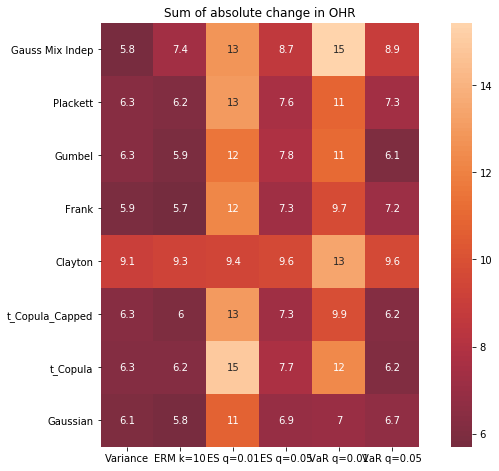

In [42]:
plt.figure(figsize=(9*1.3,6*1.3))
# sns.cubehelix_palette(as_cmap=True, reverse=True)
sns.heatmap(h_diff_df,square=True, center=True, annot=True)
plt.ylim(0,len(h_diff_df))
plt.title('Sum of absolute change in OHR')
plt.savefig(result_path+'Sum of absolute change in OHR.pdf', transparent=True)

In [43]:
h_diff_df

,Variance,ERM k=10,ES q=0.01,ES q=0.05,VaR q=0.01,VaR q=0.05
Gaussian,6.068555,5.797461,10.723926,6.904395,7.007910,6.651172
t_Copula,6.305566,6.199707,14.956445,7.726660,12.380371,6.186914
t_Copula_Capped,6.345703,6.019238,12.965527,7.316309,9.855762,6.244531
Clayton,9.080176,9.321777,9.429492,9.578809,13.426563,9.591113
Frank,5.884570,5.699414,12.252539,7.282129,9.714551,7.216602
Gumbel,6.324902,5.921777,11.529883,7.801660,11.053320,6.065625
Plackett,6.319922,6.150586,12.977344,7.636523,10.816895,7.334961
Gauss Mix Indep,5.771875,7.367090,12.840625,8.655566,15.433594,8.933691


In [44]:
# h_diff_df.iloc[[0,1,2,3,5,6,7],:].style.highlight_min(color = 'lightgreen', axis = 0)
h_diff_df.style.highlight_min(color = 'lightgreen', axis = 0)

,Variance,ERM k=10,ES q=0.01,ES q=0.05,VaR q=0.01,VaR q=0.05
Gaussian,6.068555,5.797461,10.723926,6.904395,7.007910,6.651172
t_Copula,6.305566,6.199707,14.956445,7.726660,12.380371,6.186914
t_Copula_Capped,6.345703,6.019238,12.965527,7.316309,9.855762,6.244531
Clayton,9.080176,9.321777,9.429492,9.578809,13.426563,9.591113
Frank,5.884570,5.699414,12.252539,7.282129,9.714551,7.216602
Gumbel,6.324902,5.921777,11.529883,7.801660,11.053320,6.065625
Plackett,6.319922,6.150586,12.977344,7.636523,10.816895,7.334961
Gauss Mix Indep,5.771875,7.367090,12.840625,8.655566,15.433594,8.933691


In [45]:
def hedging_effectiveness2(rm, rh, rs):
	if rm.startswith('Variance'):
		return 1 - Variance(rh) / Variance(rs)

	elif rm.startswith('ERM'):
		k = float(rm[rm.find('=') + 1:])
		return 1 - ERM_estimate_trapezoidal(k, rh) / ERM_estimate_trapezoidal(k, rs)

	elif rm.startswith('ES'):
		q = float(rm[rm.find('=') + 1:])
		return 1 - ES(q, rh) / ES(q, rs)

	elif rm.startswith('VaR'):
		q = float(rm[rm.find('=') + 1:])
		return 1 - VaR(q, rh) / VaR(q, rs)

In [46]:
for C in Copula_names:
    print(hedging_effectiveness2(rm=rm, rh=rh.loc[C,:], rs=rs))

0.4491232913926013
0.4512343961690597
0.45219702556826713
0.43864612288619065
0.44000747306446675
0.43766863661673205
0.4443194117434712
0.45889187326040004


In [47]:
HE2 = []
rm = 'ES q=0.01'
C='Gaussian'

for _ in range(1000):
    _id = np.random.choice(range(len(rh.loc[C,:])),len(rh.loc[C,:]), True)
    HE2.append(hedging_effectiveness2(rm=rm,
                                      rh=rh.loc[C,:].iloc[_id],
                                      rs=rs.iloc[_id]))
    


In [48]:
OHR.iloc[[0,1,3,4,5,6,7]]

97.csv                                                      \
                 Variance  ERM k=10 ES q=0.01 ES q=0.05 VaR q=0.01 VaR q=0.05   
Gaussian         0.798730  0.787793  0.795801  0.798242   0.782031   0.802539   
t_Copula         0.748340  0.757324  0.562988  0.722363   0.697266   0.776953   
Clayton          0.803223  0.745996  0.589258  0.700391   0.657031   0.796094   
Frank            0.786426  0.787891  0.705762  0.773340   0.761035   0.829687   
Gumbel           0.803906  0.886035  1.004590  0.924023   0.990918   0.888477   
Plackett         0.772266  0.773145  0.651855  0.745215   0.731152   0.818359   
Gauss Mix Indep  0.646191  0.708203  0.342480  0.533105   0.408594   0.665723   

                   83.csv                                ...    65.csv  \
                 Variance  ERM k=10 ES q=0.01 ES q=0.05  ... ES q=0.01   
Gaussian         0.731152  0.718750  0.736230  0.737207  ...  0.693652   
t_Copula         0.672754  0.679785  0.415137  0.644238  ...  0.413672   
Clayton          0.760254  0.704102  0.513770  0.647559  ...  0.476562   
Frank            0.725000  0.723633  0.633496  0.710937  ...  0.612891   
Gumbel           0.723535  0.804492  0.912891  0.846973  ...  0.883594   
Plackett         0.704297  0.702637  0.579980  0.682227  ...  0.560352   
Gauss Mix Indep  0.606055  0.633008  0.249023  0.478809  ...  0.235156   

                                                   71.csv                      \
                ES q=0.05 VaR q=0.01 VaR q=0.05  Variance  ERM k=10 ES q=0.01   
Gaussian         0.717969   0.756055   0.718555  0.722754  0.700098  0.667578   
t_Copula         0.630762   0.583594   0.720117  0.664648  0.668945  0.386230   
Clayton          0.625391   0.580859   0.789746  0.754297  0.706055  0.495117   
Frank            0.675098   0.622949   0.750781  0.705762  0.694336  0.590723   
Gumbel           0.837598   0.872363   0.782617  0.716699  0.791797  0.870410   
Plackett         0.661133   0.625586   0.725000  0.690430  0.682129  0.535840   
Gauss Mix Indep  0.444434   0.287500   0.614648  0.581738  0.601074  0.219238   

                                                 
                ES q=0.05 VaR q=0.01 VaR q=0.05  
Gaussian         0.704980   0.723535   0.716602  
t_Copula         0.620312   0.574512   0.703906  
Clayton          0.640332   0.582617   0.802051  
Frank            0.663086   0.614062   0.727930  
Gumbel           0.823340   0.874707   0.780859  
Plackett         0.646973   0.608984   0.716016  
Gauss Mix Indep  0.448828   0.274805   0.605859  

[7 rows x 624 columns]

In [49]:
def rename_rm(rm):
    rm = rm.replace('q=','')
    rm = rm.replace('0.01', '99%')
    rm = rm.replace('0.05', '95%')
    return rm

rename_rm('ES q=0.01')

'ES 99%'

In [50]:
OHR2 = OHR.iloc[[0,2,3,4,5,6,7]] # remove t copula, leaving only the capped version

ls = OHR.melt().variable_0.unique()
Copula_names = list(OHR2.index)
HE2 = np.ones((len(risk_measures),len(ls), len(Copula_names)))
for i, rm in enumerate(risk_measures):
    rh_arr = []
    rs_arr = []
    rf_arr = []
    for j, file in enumerate(ls):
        test = pd.read_csv(data_path +'/test/'+file)
        test.Date = pd.to_datetime(test.Date)
        rs = np.array(test.loc[:, config['spot_name']])
        rf = np.array(test.loc[:, config['future_name']])
        h_arr = OHR2.loc[:,file].loc[:,rm]
        rh = rs - np.array(h_arr).reshape((len(h_arr),-1))*rf
        rh = pd.DataFrame(rh, index=Copula_names, columns=test.Date)
        rh_arr.append(rh)

        rs = pd.Series(rs, index=test.Date)
        rf = pd.Series(rf, index=test.Date)
        rs_arr.append(rs)
        rf_arr.append(rf)
        
        for k, C in enumerate(Copula_names):
            HE2[i, j, k]= hedging_effectiveness2(rm=rm, rh=rh.loc[C,:], rs=rs)

In [51]:
OHR_results = []
for i, C in enumerate(Copula_names):
    df = OHR2.iloc[i:i+1,:].melt()
    df.columns = ['file', 'risk_measure', 'OHR']
    df.loc[:,'copula'] = C
    
    OHR_results.append(df)
    
OHR_results = pd.concat(OHR_results)

In [52]:
OHR_results

,file,risk_measure,OHR,copula
0,97.csv,Variance,0.798730,Gaussian
1,97.csv,ERM k=10,0.787793,Gaussian
2,97.csv,ES q=0.01,0.795801,Gaussian
3,97.csv,ES q=0.05,0.798242,Gaussian
4,97.csv,VaR q=0.01,0.782031,Gaussian
...,...,...,...,...
619,71.csv,ERM k=10,0.601074,Gauss Mix Indep
620,71.csv,ES q=0.01,0.219238,Gauss Mix Indep
621,71.csv,ES q=0.05,0.448828,Gauss Mix Indep
622,71.csv,VaR q=0.01,0.274805,Gauss Mix Indep


In [53]:
for i, rm in enumerate(risk_measures):
    plt.figure(figsize=(10,5))
    plt.title("Hedging Effectiveness "+ rename_rm(rm))
    plt.boxplot(HE2[i,:,:])
    plt.xticks(range(1, len(Copula_names)+1), Copula_names)
    path = '../latex/_pics/hedging_effectiveness_30days/'
    plt.savefig(path+'%s_30days.pdf'%rename_rm(rm).replace(' ', '_'))
    plt.close()


/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning:

Support for mul

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning:

Support for mul

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning:

Support for mul

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning:

Support for mul

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning:

Support for mul

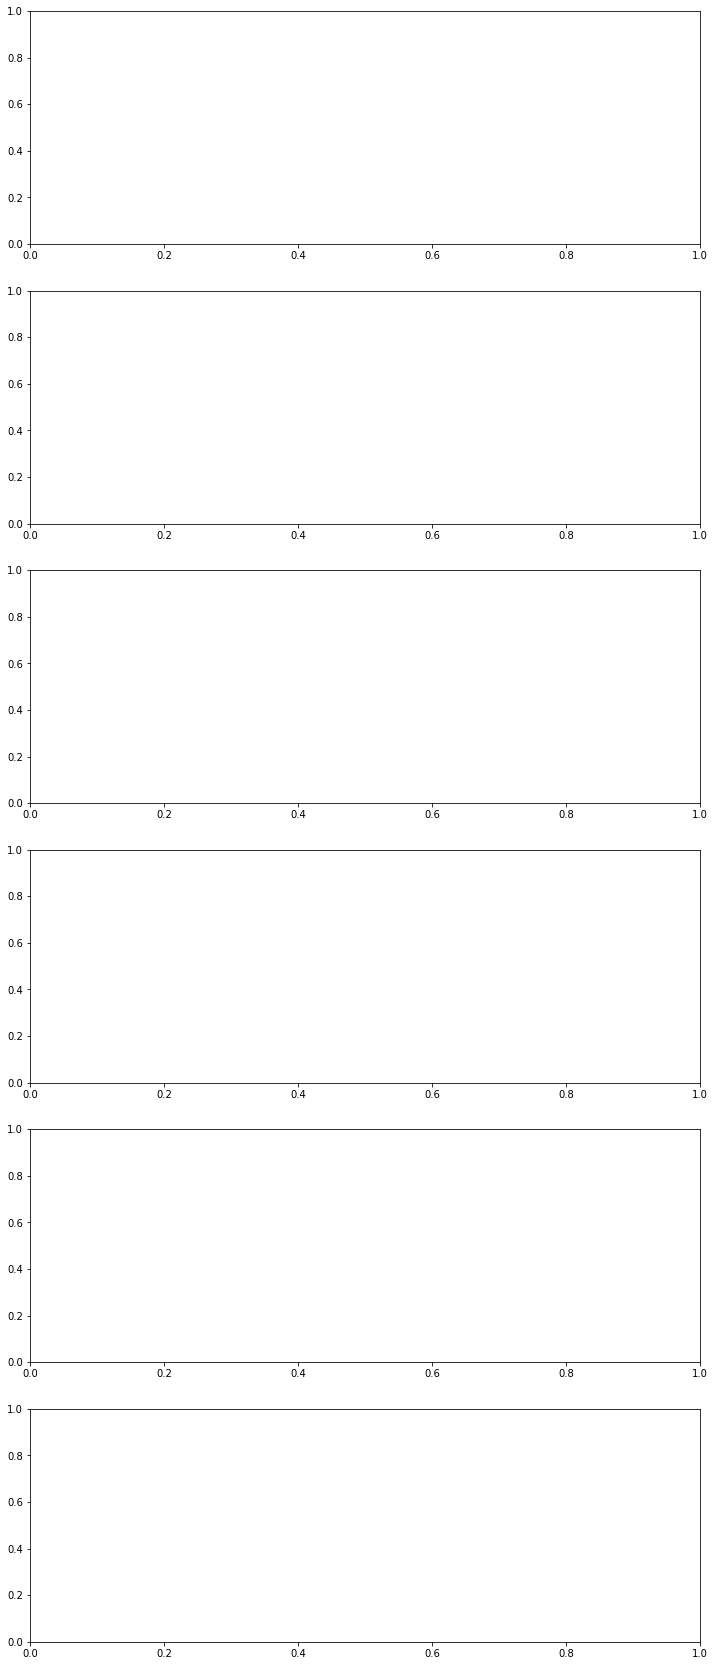

In [54]:
# _id = (rs<=np.quantile(rs,30/len(rs))) # 30 smallest rs
fig, ax = plt.subplots(len(risk_measures), 1, figsize=(12,5*len(risk_measures)))

for i, rm in enumerate(risk_measures):
    rh_arr = []
    rs_arr = []
    rf_arr = []
    for file in ls:
        test = pd.read_csv(data_path +'/test/'+file)
        test.Date = pd.to_datetime(test.Date)
        rs = np.array(test.loc[:, config['spot_name']])
        rf = np.array(test.loc[:, config['future_name']])
        h_arr = OHR2.loc[:,file].loc[:,rm]
        rh = rs - np.array(h_arr).reshape((len(h_arr),-1))*rf
        rh = pd.DataFrame(rh, index=Copula_names, columns=test.Date)
        rh_arr.append(rh)

        rs = pd.Series(rs, index=test.Date)
        rf = pd.Series(rf, index=test.Date)
        rs_arr.append(rs)
        rf_arr.append(rf)

    rh = pd.concat(rh_arr, axis=1)
    rh = rh.sort_index(axis=1)
    rs = pd.concat(rs_arr)
    rs = rs.sort_index()

    rf = pd.concat(rf_arr)
    rf = rf.sort_index()

    rh = rh.apply(pd.to_numeric)
    for C in Copula_names:
        plt.figure(figsize=(10,5))
        sns.distplot(rh.iloc[6,:])
        plt.xlabel('Log Return')
        plt.xlim((-0.15,0.15))
        plt.title('Out-of-Sample Hedged Portfolio Returns Using ' + C + ' minimizing '+ rename_rm(rm))
        path = '../latex/_pics/OOS_returns_30days/'
        plt.savefig(path+'OOS_returns_%s_%s_30days.pdf'%(C, rename_rm(rm).replace(' ', '_')))
        plt.close()#     plt.plot()

In [55]:
for i, rm in enumerate(risk_measures):
    rh_arr = []
    rs_arr = []
    rf_arr = []
    for file in ls:
        test = pd.read_csv(data_path +'/test/'+file)
        test.Date = pd.to_datetime(test.Date)
        rs = np.array(test.loc[:, config['spot_name']])
        rf = np.array(test.loc[:, config['future_name']])
        h_arr = OHR2.loc[:,file].loc[:,rm]
        rh = rs - np.array(h_arr).reshape((len(h_arr),-1))*rf
        rh = pd.DataFrame(rh, index=Copula_names, columns=test.Date)
        rh_arr.append(rh)

        rs = pd.Series(rs, index=test.Date)
        rf = pd.Series(rf, index=test.Date)
        rs_arr.append(rs)
        rf_arr.append(rf)

    rh = pd.concat(rh_arr, axis=1)
    rh = rh.sort_index(axis=1)
    rs = pd.concat(rs_arr)
    rs = rs.sort_index()

    rf = pd.concat(rf_arr)
    rf = rf.sort_index()

    rh = rh.apply(pd.to_numeric)

In [56]:
rh.iloc[i:i+1, :].melt()

,Date,value
0,2019-05-01,-0.006024
1,2019-05-02,0.001574
2,2019-05-03,0.025416
3,2019-05-06,-0.028751
4,2019-05-07,0.020052
...,...,...
515,2021-05-14,-0.029740
516,2021-05-17,-0.017145
517,2021-05-18,-0.010154
518,2021-05-19,-0.104644


In [57]:
rs

Date
2019-05-01    0.005117
2019-05-02    0.015685
2019-05-03    0.067855
2019-05-06   -0.017739
2019-05-07    0.034513
                ...   
2021-05-14    0.003599
2021-05-17   -0.134395
2021-05-18   -0.028939
2021-05-19   -0.187849
2021-05-20    0.158251
Length: 520, dtype: float64

In [58]:
plt.figure(figsize=(10,5))
sns.distplot(rf)
plt.xlabel('Log Return')
plt.xlim((-0.30,0.15))
plt.title('Out-of-Sample Bitcoin Future')

plt.savefig('OOS_BTC_future.pdf')
plt.close()#     plt.plot()

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning:

Support for mul

In [59]:
plt.figure(figsize=(10,5))
sns.distplot(rs)
plt.xlabel('Log Return')
plt.xlim((-0.30,0.15))
plt.title('Out-of-Sample BTC returns')

plt.savefig('OOS_BTC_return.pdf')
plt.close()#     plt.plot()

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning:

Support for mul

In [60]:
for C in Copula_names:
    for rm in risk_measures:
        _temp = []
        for file in ls:
            testing_file = pd.read_csv('../processed_data/'+data_name+'/test/'+file)
            testing_file.Date = pd.to_datetime(testing_file.Date)
            testing_file.loc[:,"h"] = OHR2.loc[C, file][rm]
            _temp.append(testing_file)
            
        h_to_plot = pd.concat(_temp)
        h_to_plot.sort_values("Date", inplace=True)
        
        plt.figure(figsize=(10,5))
        plt.title('Calibrated OHR by %s minimizing %s' %(C, rename_rm(rm)))
        plt.ylim((0.4,1.2))
        plt.plot(h_to_plot.Date, h_to_plot.h)
        path = '../latex/_pics/OHR_30days/'
        plt.savefig(path+'OHR_%s_%s_30days.pdf'%(C, rename_rm(rm).replace(' ', '_')))
        plt.close() 

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



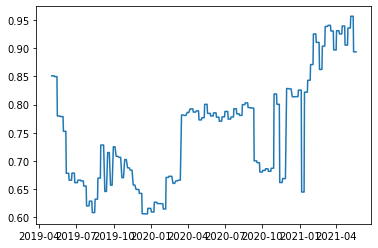

In [61]:
h_to_plot = pd.concat(_temp)
h_to_plot.sort_values("Date", inplace=True)
plt.plot(h_to_plot.Date, h_to_plot.h)

In [222]:
plt.figure(figsize=(10,5))
plt.title('Calibrated OHR by %s minimizing %s' %(C, rename_rm(rm)))
plt.ylim((0.6,1.2))
plt.plot(h_to_plot.Date, h_to_plot.h)
path = '../latex/_pics/OHR_30days/'
plt.savefig(path+'OHR_%s_%s_30days.pdf'%(C, rename_rm(rm).replace(' ', '_')))
plt.close()#     plt.plot()

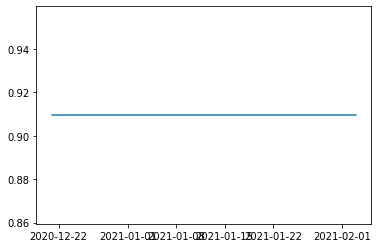

In [204]:
plt.plot(testing_file.Date, testing_file.h)

NameError: name 'rh_df' is not defined

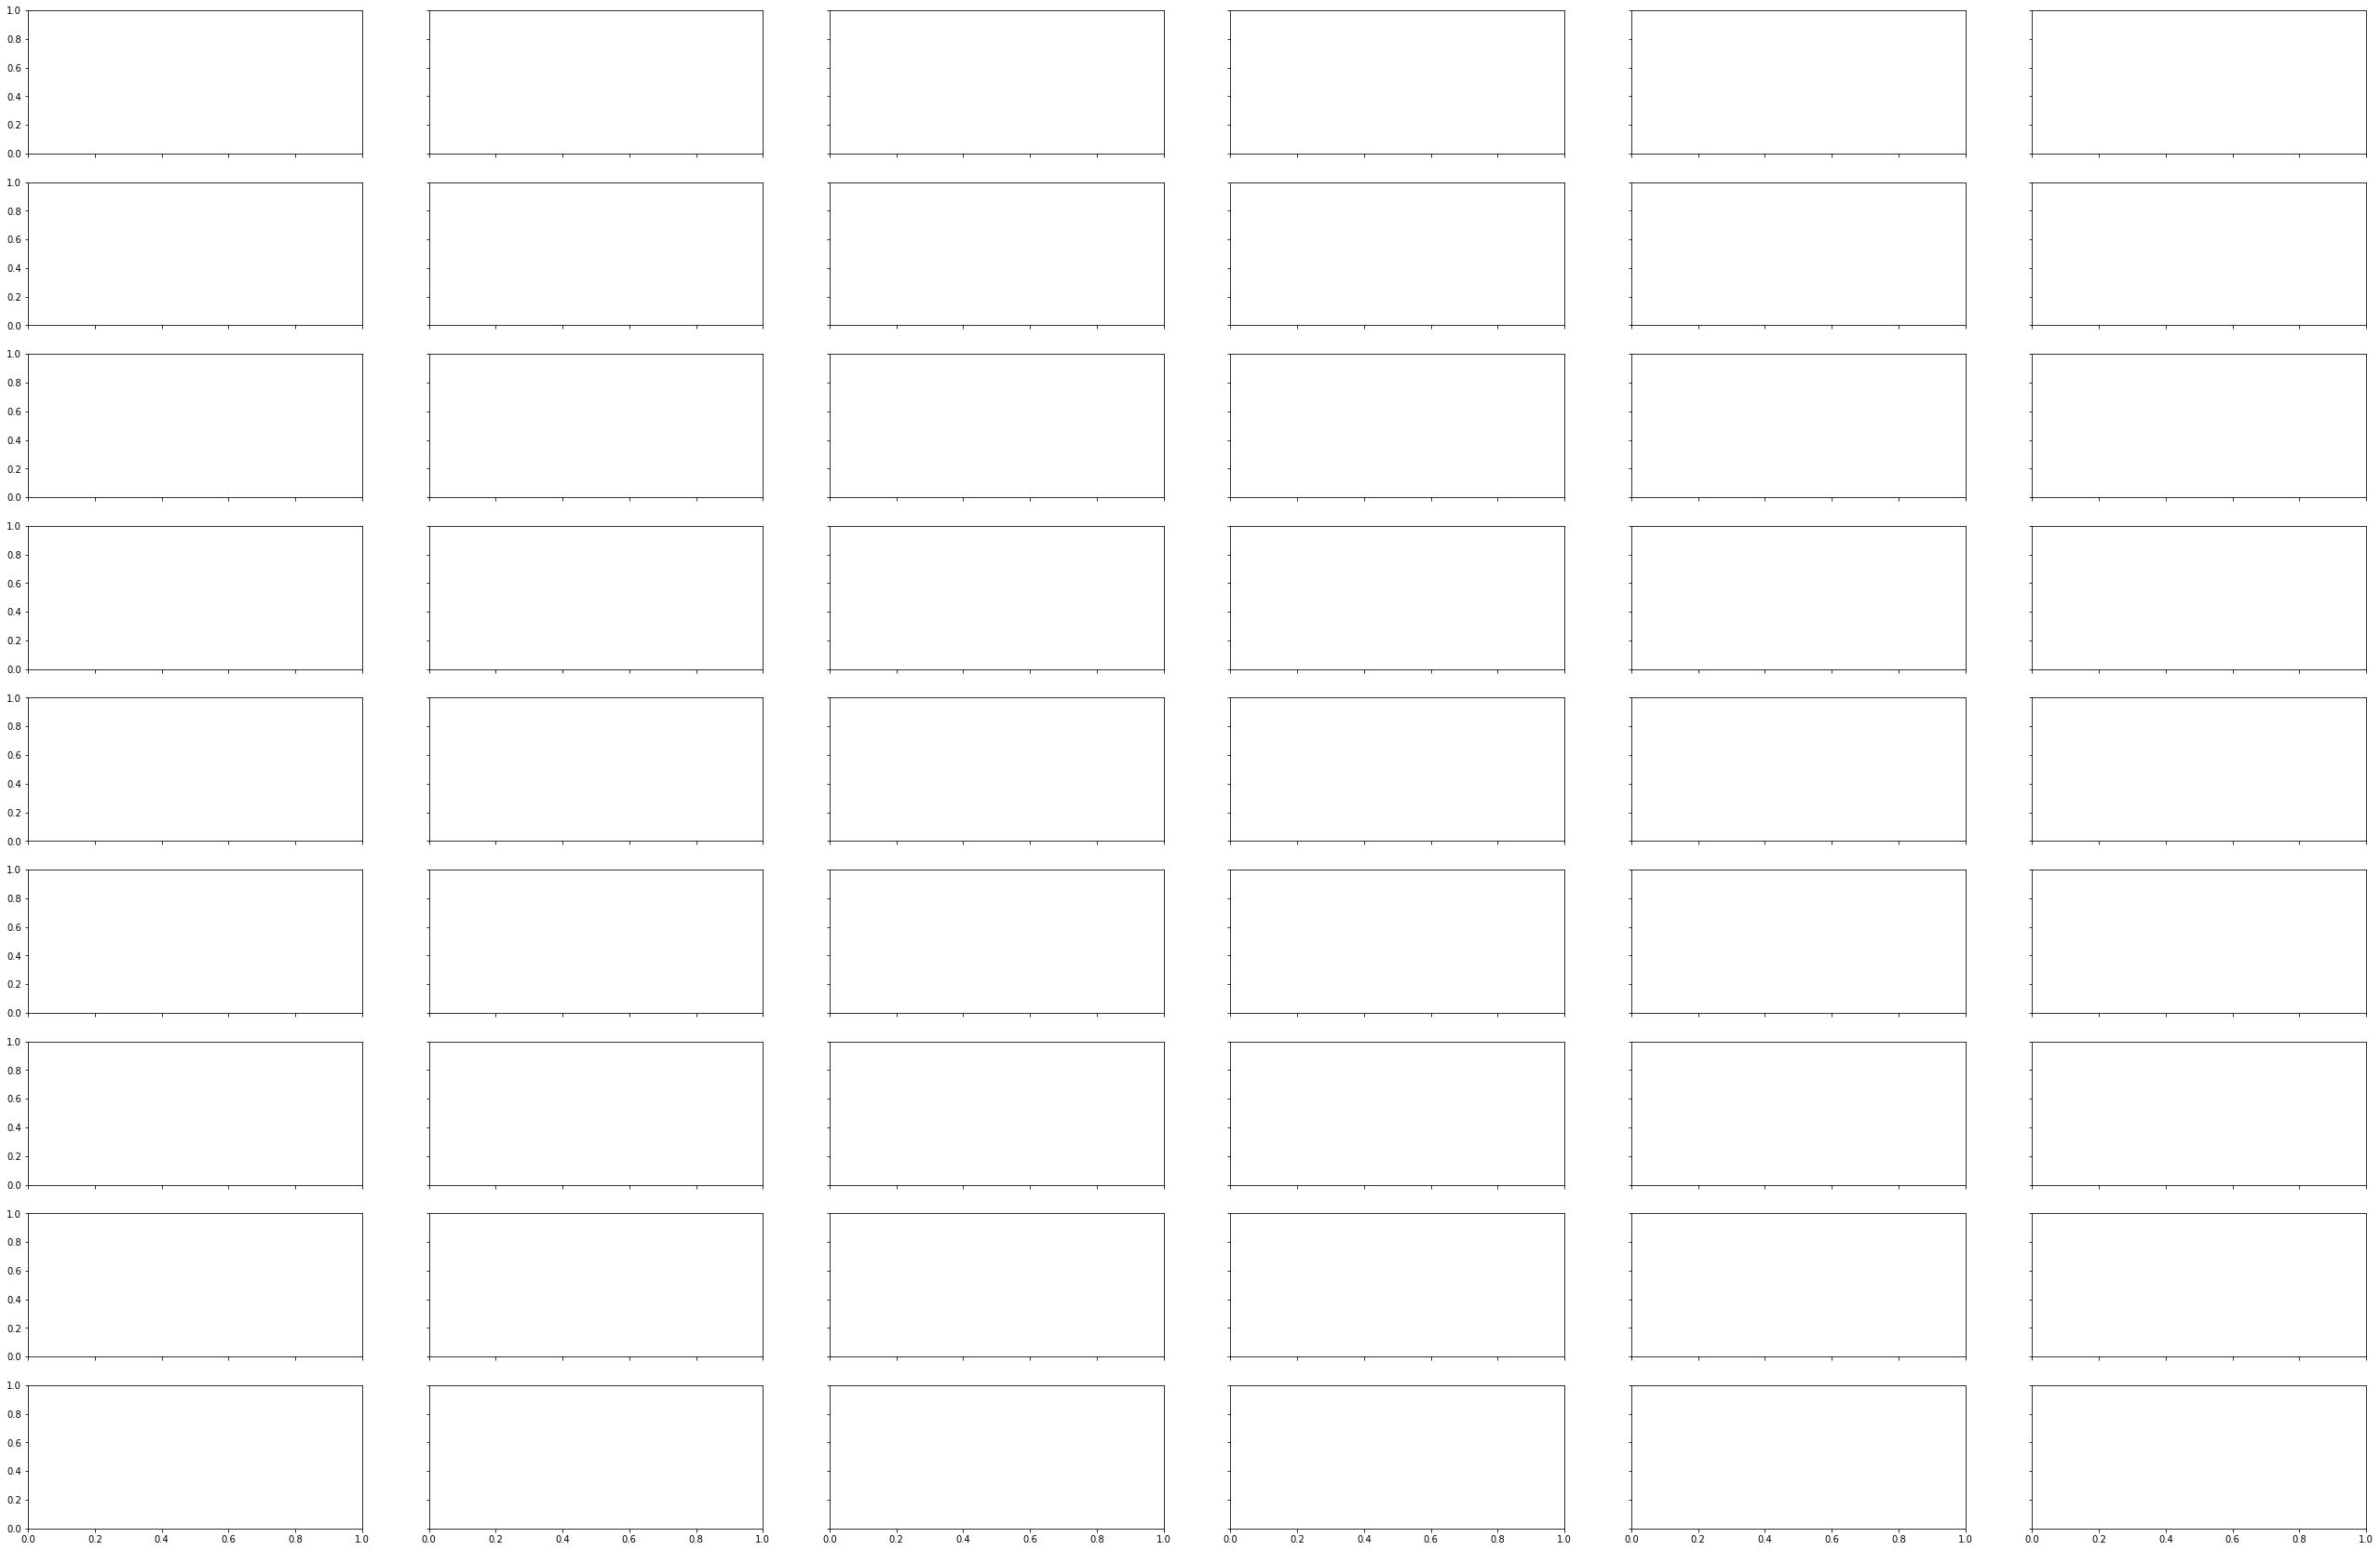

In [46]:
# N=2
fig, ax = plt.subplots(len(Copula_names),
                       len(risk_measures), 
                       figsize=(5*len(Copula_names),5*len(risk_measures)),
                       sharey=True,  sharex=True)

for i in range(len(Copula_names)):
    for j in range(len(risk_measures)):
        ax[i, j].plot(rh_df[j].T.loc[:,Copula_names[i]])
        ax[i,j].set_ylim((-0.15,0.15))
        if j==0:
            ax[i,j].set_ylabel(Copula_names[i])
        if i==0:
            ax[i,j].set_title(rename_rm(risk_measures[j]))
        ax[i,j].scatter(x= _id[_id].index, y=rh_df[j].T.loc[_id,Copula_names[i]], color='r')
plt.tight_layout(pad=0.01)
plt.savefig('../latex/_pics/Rhs.pdf', transparent=True)

In [ ]:

HE_np = np.ones((len(risk_measures), len(Copula_names)))
for i, rm in enumerate(risk_measures):
    for j, C in enumerate(Copula_names):
        HE_np[i,j]=hedging_effectiveness2(rm, rh_df[i].loc[C,:], rs)

In [ ]:
HE_overall = pd.DataFrame(HE_np).T
HE_overall.columns = [rename_rm(rm) for rm in risk_measures]
HE_overall.index = Copula_names
HE_overall.style.highlight_max(color = 'lightgreen', axis = 0)

In [ ]:
Variance_np = np.ones((len(risk_measures), len(Copula_names)))
for i, rm in enumerate(risk_measures):
    for j, C in enumerate(Copula_names):
        Variance_np[i,j]=Variance(rh_df[i].loc[C,:])**0.5
        
Variance_overall = pd.DataFrame(Variance_np).T
Variance_overall.columns = [rename_rm(rm) for rm in risk_measures]
Variance_overall.index = Copula_names
Variance_overall.style.highlight_min(color = 'lightgreen', axis = 1)

In [ ]:
Variance_overall.style.highlight_min(color = 'lightgreen', axis = 0)

In [ ]:
ERM_np = np.ones((len(risk_measures), len(Copula_names)))
for i, rm in enumerate(risk_measures):
    for j, C in enumerate(Copula_names):
        ERM_np[i,j]=ERM_estimate_trapezoidal(10, rh_df[i].loc[C,:])
        
ERM_overall = pd.DataFrame(ERM_np).T
ERM_overall.columns = [rename_rm(rm) for rm in risk_measures]
ERM_overall.index = Copula_names
ERM_overall.style.highlight_min(color = 'lightgreen', axis = 1)

In [ ]:
ERM_overall.style.highlight_min(color = 'lightgreen', axis = 0)

In [ ]:
VaR_99_np = np.ones((len(risk_measures), len(Copula_names)))
for i, rm in enumerate(risk_measures):
    for j, C in enumerate(Copula_names):
        VaR_99_np[i,j]=VaR(.01, rh_df[i].loc[C,:])
        
VaR_99_overall = pd.DataFrame(VaR_99_np).T
VaR_99_overall.columns = [rename_rm(rm) for rm in risk_measures]
VaR_99_overall.index = Copula_names
VaR_99_overall.style.highlight_min(color = 'lightgreen', axis = 1)

In [ ]:
VaR_99_overall.style.highlight_min(color = 'lightgreen', axis = 0)

In [ ]:
VaR_95_np = np.ones((len(risk_measures), len(Copula_names)))
for i, rm in enumerate(risk_measures):
    for j, C in enumerate(Copula_names):
        VaR_95_np[i,j]=VaR(.05, rh_df[i].loc[C,:])
        
VaR_95_overall = pd.DataFrame(VaR_95_np).T
VaR_95_overall.columns = [rename_rm(rm) for rm in risk_measures]
VaR_95_overall.index = Copula_names
VaR_95_overall.style.highlight_min(color = 'lightgreen', axis = 1)

In [ ]:
VaR_95_overall.style.highlight_min(color = 'lightgreen', axis = 0)

In [ ]:
ES_99_np = np.ones((len(risk_measures), len(Copula_names)))
for i, rm in enumerate(risk_measures):
    for j, C in enumerate(Copula_names):
        ES_99_np[i,j]=ES(.01, rh_df[i].loc[C,:])
        
ES_99_overall = pd.DataFrame(ES_99_np).T
ES_99_overall.columns = [rename_rm(rm) for rm in risk_measures]
ES_99_overall.index = Copula_names
ES_99_overall.style.highlight_min(color = 'lightgreen', axis = 1)

In [37]:
ES_99_overall.style.highlight_min(color = 'lightgreen', axis = 0)

NameError: name 'ES_99_overall' is not defined

In [111]:
ES_95_np = np.ones((len(risk_measures), len(Copula_names)))
for i, rm in enumerate(risk_measures):
    for j, C in enumerate(Copula_names):
        ES_95_np[i,j]=ES(.05, rh_df[i].loc[C,:])
        
ES_95_overall = pd.DataFrame(ES_95_np).T
ES_95_overall.columns = [rename_rm(rm) for rm in risk_measures]
ES_95_overall.index = Copula_names
ES_95_overall.style.highlight_min(color = 'lightgreen', axis = 1)

,ERM k=10,ES 99%,ES 95%,VaR 99%,VaR 95%,Variance
Gaussian,0.0347774,0.035638,0.0348519,0.0359094,0.0349944,0.0342865
t_Copula,0.0350866,0.0379191,0.0356037,0.036435,0.0346707,0.0345252
t_Copula_Capped,0.0349005,0.0360371,0.0351585,0.0355429,0.0347392,0.0343704
Clayton,0.0339855,0.0381297,0.0345452,0.0355141,0.0334452,0.0340916
Frank,0.0525252,0.047122,0.0555002,0.0533276,0.034765,0.0459337
Gumbel,0.0340553,0.0364684,0.0346499,0.0361854,0.0337115,0.0342506
Plackett,0.0347486,0.0374588,0.03557,0.0362724,0.0341403,0.0344715
Gauss Mix Indep,0.0347216,0.0456495,0.0354895,0.0398294,0.0338411,0.034777
NIG_factor,0.0343159,0.0419507,0.0371707,0.0377039,0.0350889,0.034999


In [112]:
ES_95_overall.style.highlight_min(color = 'lightgreen', axis = 0)

,ERM k=10,ES 99%,ES 95%,VaR 99%,VaR 95%,Variance
Gaussian,0.0347774,0.035638,0.0348519,0.0359094,0.0349944,0.0342865
t_Copula,0.0350866,0.0379191,0.0356037,0.036435,0.0346707,0.0345252
t_Copula_Capped,0.0349005,0.0360371,0.0351585,0.0355429,0.0347392,0.0343704
Clayton,0.0339855,0.0381297,0.0345452,0.0355141,0.0334452,0.0340916
Frank,0.0525252,0.047122,0.0555002,0.0533276,0.034765,0.0459337
Gumbel,0.0340553,0.0364684,0.0346499,0.0361854,0.0337115,0.0342506
Plackett,0.0347486,0.0374588,0.03557,0.0362724,0.0341403,0.0344715
Gauss Mix Indep,0.0347216,0.0456495,0.0354895,0.0398294,0.0338411,0.034777
NIG_factor,0.0343159,0.0419507,0.0371707,0.0377039,0.0350889,0.034999


In [113]:
# print("\\begin{table}")
# print(ERM_overall.to_latex(index=True))
# print("\\caption{Exponential Risk Measure $k=10$}")
# print("\\end{table}")

# print("\\begin{table}")
# print(ES_99_overall.to_latex(index=True))
# print("\\caption{ES 99\%}")
# print("\\end{table}")

# print("\\begin{table}")
# print(ES_95_overall.to_latex(index=True))
# print("\\caption{ES 95\%}")
# print("\\end{table}")

print("\\begin{table}")
print(VaR_99_overall.to_latex(index=True))
print("\\caption{VaR 99\%}")
print("\\end{table}")

# print("\\begin{table}")
# print(VaR_95_overall.to_latex(index=True))
# print("\\caption{VaR 95\%}")
# print("\\end{table}")

# print("\\begin{table}")
# print(Variance_overall.to_latex(index=True))
# print("\\caption{Variance}")
# print("\\end{table}")


\begin{table}
\begin{tabular}{lrrrrrr}
\toprule
{} &  ERM k=10 &    ES 99\% &    ES 95\% &   VaR 99\% &   VaR 95\% &  Variance \\
\midrule
Gaussian        &  0.041453 &  0.045906 &  0.042359 &  0.046327 &  0.041644 &  0.042227 \\
t\_Copula        &  0.041877 &  0.044826 &  0.043668 &  0.046009 &  0.041553 &  0.042282 \\
t\_Copula\_Capped &  0.041701 &  0.045309 &  0.043019 &  0.046239 &  0.041416 &  0.042255 \\
Clayton         &  0.039866 &  0.046187 &  0.041015 &  0.045725 &  0.040455 &  0.042305 \\
Frank           &  0.068284 &  0.056641 &  0.074298 &  0.068848 &  0.040503 &  0.054027 \\
Gumbel          &  0.042739 &  0.043390 &  0.042397 &  0.045773 &  0.041262 &  0.042102 \\
Plackett        &  0.040971 &  0.045065 &  0.042511 &  0.045826 &  0.040423 &  0.041847 \\
Gauss Mix Indep &  0.041138 &  0.049952 &  0.044375 &  0.045059 &  0.040761 &  0.043000 \\
NIG\_factor      &  0.041510 &  0.047636 &  0.043426 &  0.045355 &  0.042359 &  0.043242 \\
\bottomrule
\end{tabular}

\caption{Va

In [66]:
h_4plot_arr = []
_rh = rh.loc[C,:]

for rm in risk_measures:
    dates = [pd.read_csv(data_path +'/test/'+file).iloc[-1,:].Date for file in ls]
    end_date = _rh.index[-1]
    h_4plot = pd.concat([OHR.loc[:, file].loc[:,rm] for file in ls],keys = dates, axis=1)
    h_4plot = h_4plot.sort_index(axis=1)
    h_4plot.loc[:,end_date] = h_4plot.iloc[:,-1]
    h_4plot.columns = pd.to_datetime(h_4plot.columns)
    h_4plot_arr.append(h_4plot)

ValueError: Tz-aware datetime.datetime cannot be converted to datetime64 unless utc=True

In [40]:
risk_measures

Index(['ERM k=10', 'ES q=0.01', 'ES q=0.05', 'VaR q=0.01', 'VaR q=0.05',
       'Variance'],
      dtype='object')

In [48]:
# fig, ax = plt.subplots(len(Copula_names),
#                        len(risk_measures), 
#                        figsize=(5*len(Copula_names),5*len(risk_measures)),
#                        sharey=True,  sharex=True)

# for i in range(len(Copula_names)):
#     for j in range(len(risk_measures)):
#         ax[i, j].plot(rh_df[j].T.loc[:,Copula_names[i]])
#         ax[i,j].set_ylim((-0.15,0.15))
#         if j==0:
#             ax[i,j].set_ylabel(Copula_names[i])
#         if i==0:
#             ax[i,j].set_title(rename_rm(risk_measures[j]))
#         ax[i,j].scatter(x= _id[_id].index, y=rh_df[j].T.loc[_id,Copula_names[i]], color='r')
# plt.tight_layout(pad=0.01)
# plt.savefig('../latex/_pics/Rhs.png', transparent=True)

NameError: name 'h_4plot_arr' is not defined

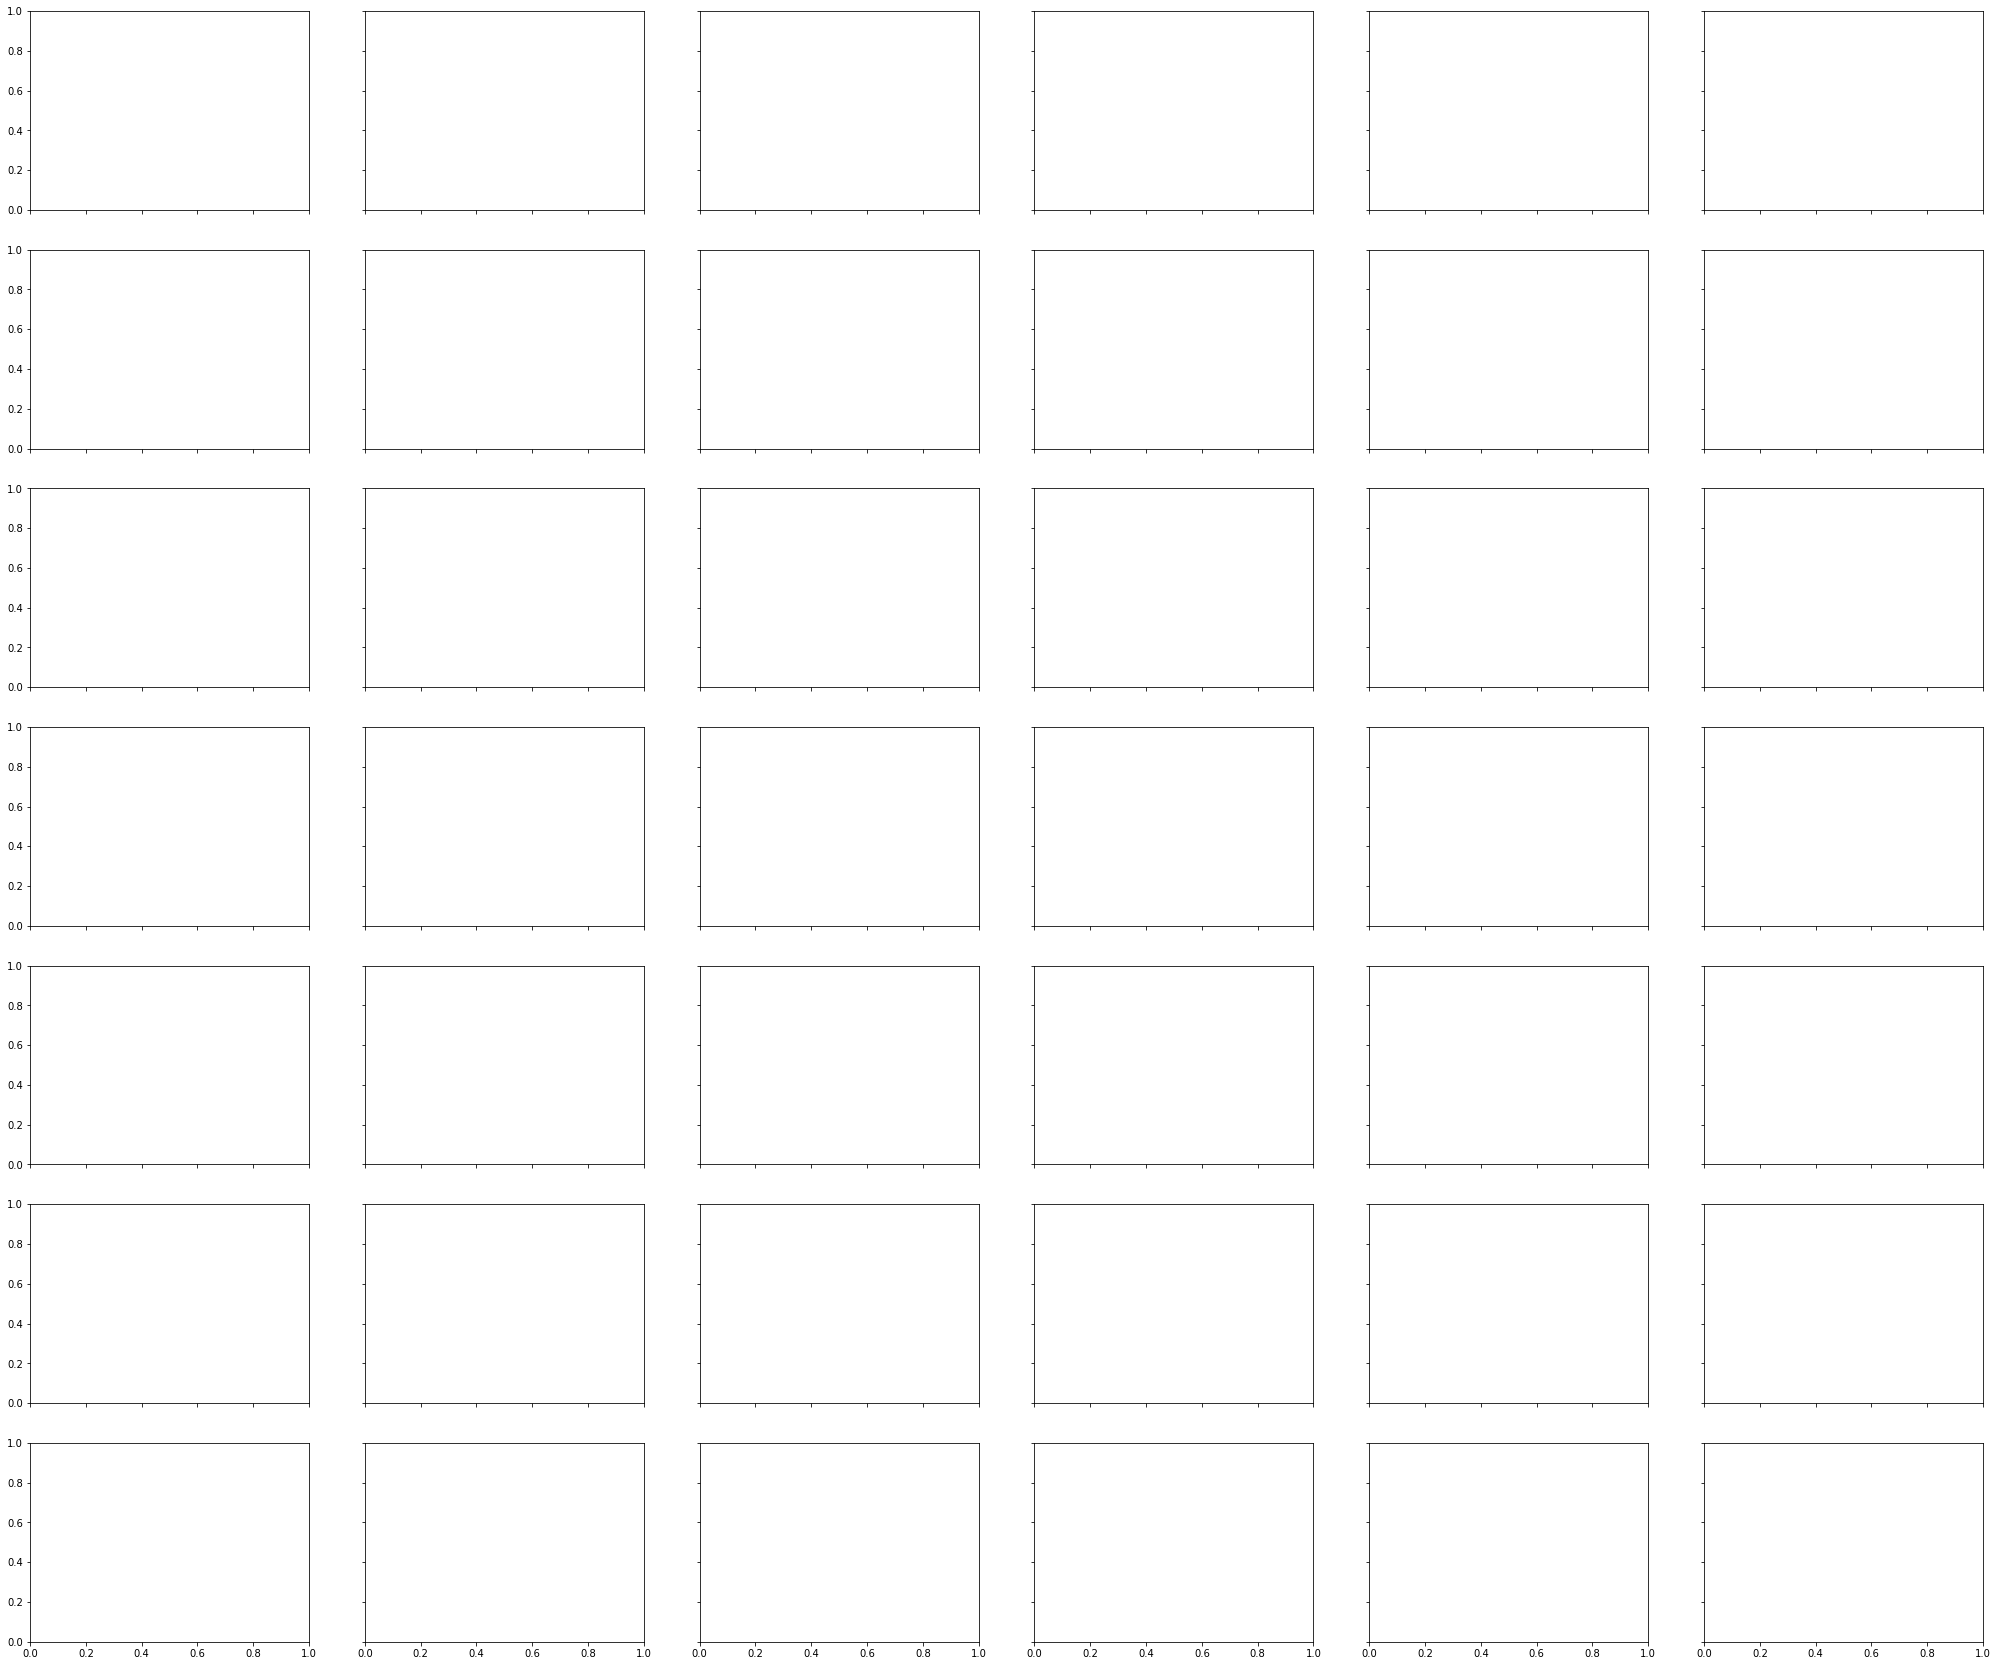

In [65]:
fig, ax = plt.subplots(len(Copula_names),
                       len(risk_measures), 
                       figsize=(5*len(Copula_names),5*len(risk_measures)),
                       sharey=True,  sharex=True)


for i, C in enumerate(Copula_names):
    for j, rm in enumerate(risk_measures):
        ax[i,j].step(x=h_4plot_arr[j].loc[C,:].index, y=h_4plot_arr[j].loc[C,:], label=risk_measures[j])
        if j==0:
            ax[i,j].set_ylabel(Copula_names[i])
        if i==0:
            ax[i,j].set_title(rename_rm(risk_measures[j]))
plt.tight_layout(pad=0.01)
plt.savefig('../latex/_pics/OHRs_CRIX_future_Open.pdf', transparent=True)

The overall strategy:
1. observe copula across risk reduction objective
- Kick out Frank because of HEs and PnL
- Other copula are producing similar results of HEs and PnL under the same risk reduction objective
-- PnL, conditional PnL (conditioned on extremes of RS)
- Gumbel Copula ex-ante hedge extreme by keeping a high h*
- None of the copula can escape from dependence break 

2. observe risk reduction objectives across copula
- 99% VaR and ES are too sensitive 
- ERM is a smoothed version ES --> give consistent results

1. h is high to begin with, Gumbel is consistently high, pick some of the extreme better then the others
2. consistently high h 

normal time, no extreme, h<<1
if there is extreme, correltation is higher, if one concerns extremes, maintain high h before extremes
connection to Gumbel
- combination of risk reduction objective and copula produce sensitive h*s. 
- Gumbel is better on extremes,because there is a high h ex-ante. high capture the 
- 
